In [1]:
import tensorflow as tf
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#np.set_printoptions(threshold=np.inf)
import time
import csv

In [2]:
##tr 0 to 3 is location value
ecg_filename = ["time_ecg_rpeak_yeop_sleep", "time_ecg_rpeak_yeopdata", "time_ecg_rpeak_yeop_friend_sleep"]

In [3]:
ecg_header = []
ecg_time = []
ecg_code = []
rpeak_time = []
rpeak_code = []
peak_index = []

In [4]:
def read_ecg_from_csv(ecg_filename):
    filename = "data/"+ecg_filename+".CSV"
    with open (filename,'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter = ',')
        ecg_header.append(reader.next())
        for row in reader:
            ecg_time.append(row[0])
            ecg_code.append(float(row[1]))
            rpeak_time.append(row[2])
            rpeak_code.append(row[3])
            if row[3] != "0":
                peak_index.append(row)

In [5]:
read_ecg_from_csv(ecg_filename[0])

In [6]:
print("peak_point_number : " + str(len(peak_index))+
      "\necg_data_number : "+str(len(ecg_time)))

peak_point_number : 4195
ecg_data_number : 1048575


In [7]:
x_ = ecg_code[:287000]

x_temp = np.linspace(-10, 10, 500)
x_x_temp = map(lambda x: x*x + 2400, x_temp)
x_x_temp = (287*2)*x_x_temp
x_[287000:]=x_x_temp
print len(x_)

tr_x =  np.reshape(x_,[-1,500])

574000


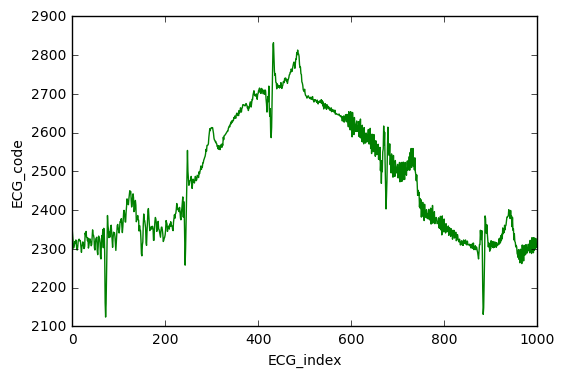

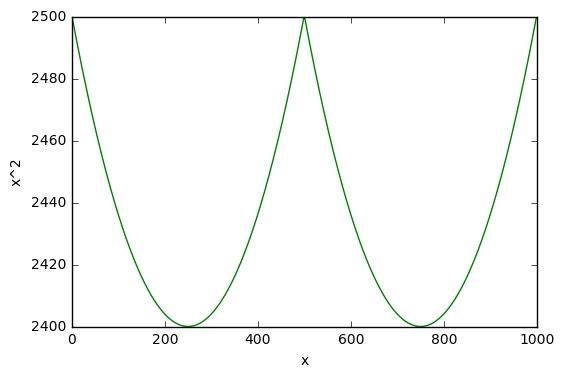

In [8]:
plt.plot(ecg_code[:1000],'g-')
plt.xlabel('ECG_index')
plt.ylabel('ECG_code')
plt.show()
plt.plot(x_x_temp[:1000],'g-')
plt.xlabel('x')
plt.ylabel('x^2')
plt.show()

In [9]:
y_= np.zeros((574*2,2), dtype = "float32")
for i in range(0,574*2):
    if i < 574:
        y_[i][0] = 1.0
    else:
        y_[i][1] = 1.0
print y_

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


In [10]:
ecg_header = []
ecg_time = []
ecg_code = []
rpeak_time = []
rpeak_code = []
peak_index = []

In [11]:
read_ecg_from_csv(ecg_filename[1])
print("peak_point_number : " + str(len(peak_index))+
      "\necg_data_number : "+str(len(ecg_time)))

peak_point_number : 2865
ecg_data_number : 587648


In [12]:
x_t = ecg_code[:87000*2]
x_temp = np.linspace(-0.8, 0.8, 500)
x_x_temp = map(lambda x: x*x, x_temp)
x_x_temp = (87*2)*x_x_temp

x_t[:87000] =x_x_temp

te_x =  np.reshape(x_t,[-1,500])

te_y= np.zeros((87*4,2), dtype = "float32")
for i in range(0,87*4):
    if i < 87*2:
        te_y[i][1]=1.0
    else :
        te_y[i][0]=1.0

In [13]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [14]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides = [1,1,1,1], padding = 'SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 25, 1, 1] ,
                         strides = [1, 25, 1, 1], padding='SAME')

In [15]:
Y = tf.placeholder("float32",shape = [None,2])
X = tf.placeholder("float32",shape = [None, 500]) 

x_image = tf.reshape(X,[-1,500,1,1])

In [16]:
W_conv1 = weight_variable([250, 1, 1, 4])
b_conv1 = bias_variable([4])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [17]:
W_conv2 = weight_variable([250, 1, 4, 8])
b_conv2 = bias_variable([8])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [18]:
print(x_image.get_shape())
print(h_conv1.get_shape())
h_pool1.get_shape()

(?, 500, 1, 1)
(?, 500, 1, 4)


TensorShape([Dimension(None), Dimension(20), Dimension(1), Dimension(4)])

In [19]:
print(h_conv2.get_shape())
h_pool2.get_shape()

(?, 20, 1, 8)


TensorShape([Dimension(None), Dimension(1), Dimension(1), Dimension(8)])

In [20]:
W_fc1 = weight_variable([1 * 1 * 8, 4])
b_fc1 = bias_variable([4])

h_pool2_flat = tf.reshape(h_pool2, [-1, 1 * 1 * 8])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [21]:
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [22]:
W_fc2 = weight_variable([4, 2])
b_fc2 = bias_variable([2])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [23]:
cross_entropy =-tf.reduce_sum(y_*tf.log(y_conv + 1e-10))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [24]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

start_time = time.time()
for step in range(1000):
    if (step % 200) == 0:
        print sess.run(accuracy,feed_dict = {X: te_x, Y: te_y,keep_prob:1})*100
    result = sess.run(train_step, feed_dict = {X: tr_x, Y: y_, keep_prob:0.5})

result = sess.run(accuracy,feed_dict = {X: te_x, Y: te_y,keep_prob:1})*100
excute_time = time.time() - start_time

50.0
27.5862067938
41.6666686535
48.8505721092
98.5632181168


In [25]:
print y_conv.eval({X: tr_x, keep_prob:0.5},sess)
print y_conv.eval({X: te_x, keep_prob:1},sess)

[[ 0.97402054  0.02597949]
 [ 0.12890136  0.8710987 ]
 [ 0.98812497  0.01187507]
 ..., 
 [ 0.47758293  0.52241701]
 [ 0.47758293  0.52241701]
 [ 0.0988546   0.90114534]]
[[ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.5173896 ]
 [ 0.48261046  0.517

In [26]:
print result
print excute_time

99.7126460075
164.041113138


In [27]:
x_temp = np.linspace(-10, 10, 500)
x_x_temp = map(lambda x: x*(x+10)+10000,x_temp)
x_x_temp = (87*2)*x_x_temp
x_x_temp = np.reshape(x_x_temp, [-1,500])
print y_conv.eval({X: x_x_temp, keep_prob:1},sess)

[[ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 [ 0.03347754  0.96652246]
 

In [28]:
ecg_header = []
ecg_time = []
ecg_code = []
rpeak_time = []
rpeak_code = []
peak_index = []

In [29]:
read_ecg_from_csv(ecg_filename[2])

In [30]:
print len(ecg_code)

1048575


In [31]:
x = ecg_code[:1048500] 
x = np.reshape(x, [-1,500])
print y_conv.eval({X: x, keep_prob:1},sess)

[[  9.99997854e-01   2.11905535e-06]
 [  1.00000000e+00   4.34148149e-08]
 [  9.98935044e-01   1.06491800e-03]
 ..., 
 [  9.99982119e-01   1.78539212e-05]
 [  9.99891996e-01   1.08026688e-04]
 [  9.99596179e-01   4.03865823e-04]]
